In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List

In [2]:
df = pd.read_csv("AAPL_candles.csv", index_col = 0)
df.head()

,open,close,low,high,volume
0,132.69,132.69,132.63,132.69,10522182
1,132.99,134.19,132.99,135.00,11368
2,134.25,134.33,134.00,134.50,5602
3,134.30,133.75,133.36,134.30,7612
4,133.75,134.40,133.61,134.48,8333


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4692 entries, 0 to 4691
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    4692 non-null   float64
 1   close   4692 non-null   float64
 2   low     4692 non-null   float64
 3   high    4692 non-null   float64
 4   volume  4692 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 219.9 KB


In [4]:
dates = []
start_day = datetime(2021, 1, 1)

for i in range(len(df)):
    dates.append(start_day + timedelta(hours=1*i))

df = df.assign(date = dates)
df.head()

,open,close,low,high,volume,date
0,132.69,132.69,132.63,132.69,10522182,2021-01-01 00:00:00
1,132.99,134.19,132.99,135.00,11368,2021-01-01 01:00:00
2,134.25,134.33,134.00,134.50,5602,2021-01-01 02:00:00
3,134.30,133.75,133.36,134.30,7612,2021-01-01 03:00:00
4,133.75,134.40,133.61,134.48,8333,2021-01-01 04:00:00


<AxesSubplot:xlabel='date'>

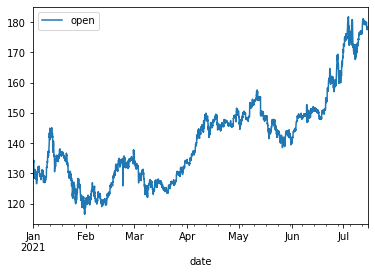

In [5]:
df.plot(x="date", y="open")

<AxesSubplot:xlabel='date'>

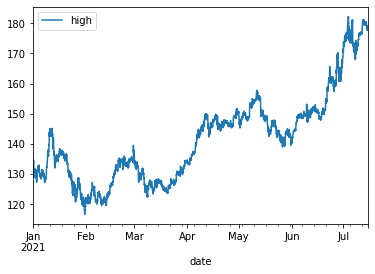

In [6]:
df.plot(x="date", y="high")

In [7]:
df[["open", "close", "low", "high"]].corr()

,open,close,low,high
open,1.000000,0.999314,0.999411,0.999576
close,0.999314,1.000000,0.999502,0.999572
low,0.999411,0.999502,1.000000,0.999030
high,0.999576,0.999572,0.999030,1.000000


In [8]:
train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

train_df.shape, test_df.shape

((3753, 6), (939, 6))

In [9]:
scaler = StandardScaler()
scaler.fit(train_df[["low"]])

def make_dataset(
    df,
     window_size,
     batch_size,
     use_scaler=True,
     shuffle=True
     ):
  features = df[["low"]].iloc[:-window_size]
  if use_scaler:
    features = scaler.transform(features)
  data = np.array(features, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=df["low"].iloc[window_size:],
      sequence_length=window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=batch_size)
  return ds

In [10]:
example_ds = make_dataset(df=train_df, window_size=3, batch_size=2, use_scaler=False, shuffle=False)

2022-05-17 10:39:10.194750: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
example_feature, example_label = next(example_ds.as_numpy_iterator())

In [12]:
example_feature.shape

(2, 3, 1)

In [13]:
example_label.shape

(2,)

In [14]:
train_df["low"].iloc[:6]

0    132.63
1    132.99
2    134.00
3    133.36
4    133.61
5    134.00
Name: low, dtype: float64

In [15]:
print(example_feature[0])
print(example_label[0])

[[132.63]
 [132.99]
 [134.  ]]
133.36


In [16]:
print(example_feature[1])
print(example_label[1])

[[132.99]
 [134.  ]
 [133.36]]
133.61


In [17]:
window_size = 10
batch_size = 8
train_ds = make_dataset(df=train_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)
val_ds = make_dataset(df=test_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle=True)

In [18]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [19]:
def compile_and_fit(model, train_ds, val_ds, num_epochs: int = 20):
  model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(),
        metrics=[tf.metrics.MeanAbsoluteError()]
      )
  history = model.fit(
      train_ds,
      epochs=num_epochs,
      validation_data=val_ds,
      verbose=0
      )
  return history

In [20]:
history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=100)

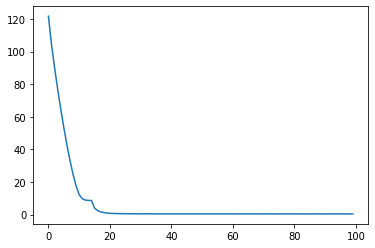

In [21]:
plt.plot(history.history['mean_absolute_error'])

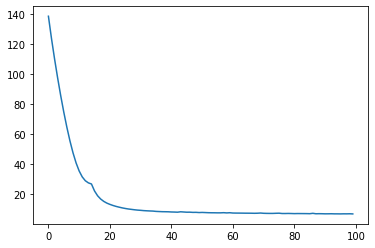

In [22]:
plt.plot(history.history['val_mean_absolute_error'])

In [23]:
lstm_model.evaluate(train_ds)

467/467 [==============================] - 1s 1ms/step - loss: 0.3443 - mean_absolute_error: 0.3589

[0.3442726731300354, 0.35893890261650085]

In [24]:
lstm_model.evaluate(val_ds)

115/115 [==============================] - 0s 1ms/step - loss: 95.2661 - mean_absolute_error: 6.6073


[95.26607513427734, 6.607254505157471]

In [25]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=100)

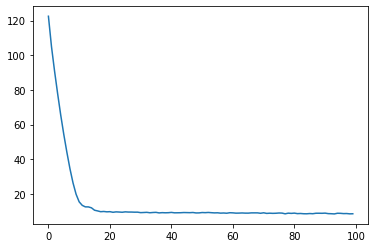

In [26]:
plt.plot(history.history['mean_absolute_error'])

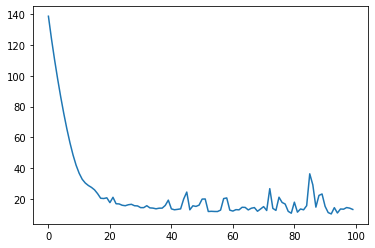

In [27]:
plt.plot(history.history['val_mean_absolute_error'])

In [28]:
lstm_model.evaluate(train_ds)

467/467 [==============================] - 1s 1ms/step - loss: 0.5421 - mean_absolute_error: 0.4949

[0.542116105556488, 0.49487102031707764]

In [29]:
lstm_model.evaluate(val_ds)

115/115 [==============================] - 0s 2ms/step - loss: 418.2229 - mean_absolute_error: 12.9985


[418.2228698730469, 12.99846363067627]